<a href="https://colab.research.google.com/github/mengjie514/Dynamic-Social-Network-Analysis/blob/main/Setiment_Content_Analysis_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import standard libraries
import os
import warnings
from io import open

# Import third-party libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch

# Import Google Colab drive for accessing Google Drive files
from google.colab import drive

# Function to mount Google Drive and change directory
def setup_drive(mount_point: str, target_directory: str):
    """
    Mounts Google Drive and changes the working directory to the target directory.

    Parameters:
        mount_point (str): The mount point for Google Drive.
        target_directory (str): The directory path within Google Drive to navigate to.
    """
    drive.mount(mount_point)
    os.chdir(target_directory)

# Function to configure environment settings
def configure_environment():
    """
    Configures display options for Pandas and suppresses specified warnings.
    """
    # Set the maximum column width for display in Pandas
    pd.set_option('display.max_colwidth', None)

    # Suppress UserWarnings related to fuzzywuzzy or other packages
    warnings.simplefilter(action='ignore', category=UserWarning)

# Main setup function
def main():
    """
    Main function to set up the environment for social network analysis.
    """
    # Define mount point and target directory (generalized paths)
    MOUNT_POINT = '/content/gdrive'
    TARGET_DIRECTORY = '/path/to/Colab_Notebooks/PSVI/Raw_Data_2022Midterm'

    # Mount Google Drive and change directory
    setup_drive(MOUNT_POINT, TARGET_DIRECTORY)

    # Configure environment settings
    configure_environment()

    # Additional setup steps can be added here

# Execute the main function
if __name__ == "__main__":
    main()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


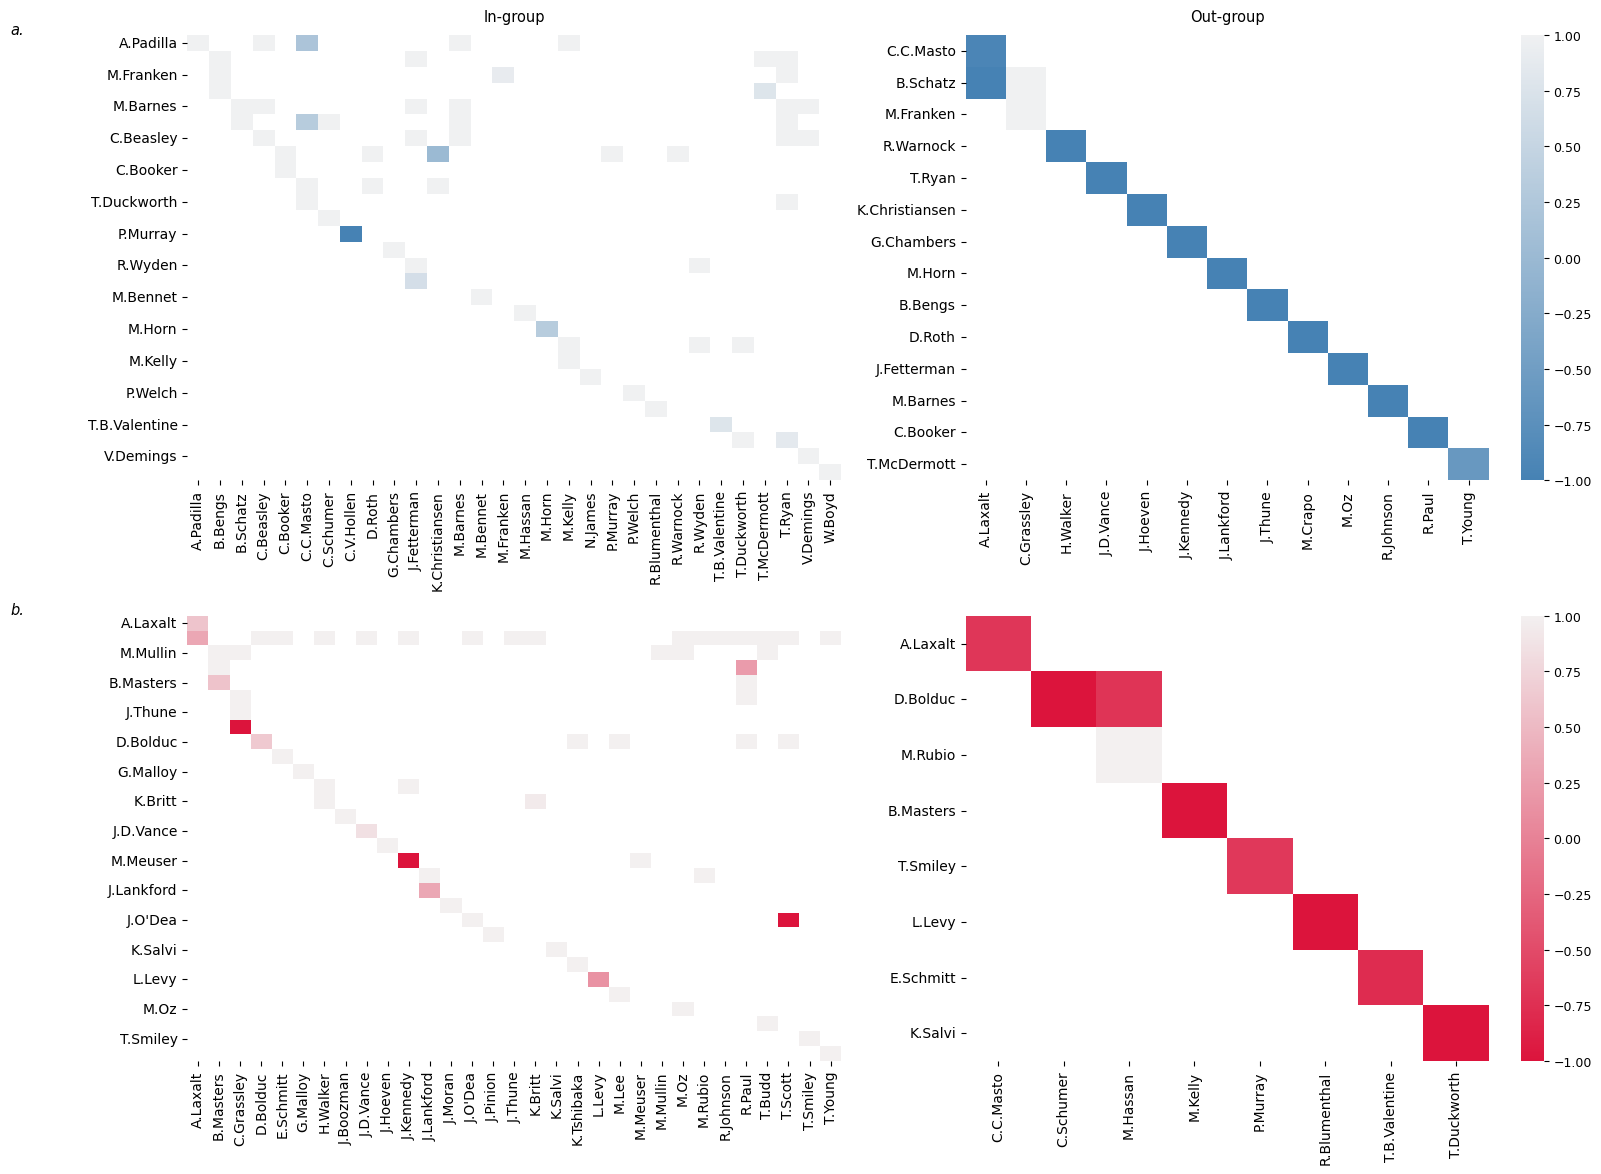

In [ ]:
# Function to load and preprocess data
def load_and_preprocess_data(file_path: str, replace_dict: dict) -> pd.DataFrame:
    """
    Loads the dataset from a CSV file, replaces specified values, and preprocesses sentiment data.

    Parameters:
        file_path (str): Path to the CSV file containing the dataset.
        replace_dict (dict): Dictionary for replacing values in 'screen_name' and 'connected_screen_name'.

    Returns:
        pd.DataFrame: Cleaned and preprocessed DataFrame.
    """
    # Load the dataset
    df = pd.read_csv(file_path, encoding='utf-8')

    # Replace values in 'screen_name' and 'connected_screen_name'
    df = df.replace({'screen_name': replace_dict, 'connected_screen_name': replace_dict})

    # Clean and preprocess the data
    df.drop(columns=['Sentiment'], inplace=True, errors='ignore')
    df.rename(columns={'StandardizedSentiment': 'Sentiment'}, inplace=True)
    df['Sentiment'] = df['Sentiment'].map({'Positive': 1, 'Negative': -1, 'Neutral': 0})
    df = df[df['Sentiment'] != 0]

    return df

# Function to aggregate sentiment data
def aggregate_sentiment(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregates the DataFrame to calculate mean sentiment scores grouped by relevant columns.

    Parameters:
        df (pd.DataFrame): Cleaned DataFrame containing sentiment data.

    Returns:
        pd.DataFrame: Aggregated DataFrame with average sentiment scores and group classifications.
    """
    group_columns = [
        'screen_name',
        'screen_name_party',
        'connected_screen_name',
        'connected_screen_name_party'
    ]

    average_sentiment = df.groupby(group_columns).agg({'Sentiment': 'mean'}).reset_index()
    average_sentiment['Group'] = np.where(
        average_sentiment['screen_name_party'] == average_sentiment['connected_screen_name_party'],
        'Ingroup',
        'Outgroup'
    )

    return average_sentiment

# Function to create pivot tables for heatmaps
def create_pivot_tables(average_sentiment: pd.DataFrame) -> dict:
    """
    Creates pivot tables for heatmap visualization based on group type and party affiliation.

    Parameters:
        average_sentiment (pd.DataFrame): Aggregated DataFrame with average sentiment scores.

    Returns:
        dict: Nested dictionary containing pivot tables for each group and party.
    """
    groupings = {'Ingroup': 'Group == "Ingroup"', 'Outgroup': 'Group == "Outgroup"'}
    parties = {'D': 'screen_name_party == "D"', 'R': 'screen_name_party == "R"'}

    data = {
        group: {
            party: average_sentiment.query(f"{groupings[group]} and {parties[party]}")
            for party in parties
        }
        for group in groupings
    }

    heatmaps = {
        group: {
            party: data[group][party].pivot(
                index='screen_name',
                columns='connected_screen_name',
                values='Sentiment'
            )
            for party in parties
        }
        for group in groupings
    }

    # Sort values for better visualization
    for group in heatmaps:
        for party in heatmaps[group]:
            heatmaps[group][party] = heatmaps[group][party].sort_values(
                by=list(heatmaps[group][party].columns),
                ascending=False
            )

    return heatmaps

# Function to format y-axis labels as integers
def int_formatter(x, pos):
    return f'{int(x)}'

# Function to plot heatmaps
def plot_heatmaps(heatmaps: dict):
    """
    Generates heatmaps for average sentiment scores based on group type and party affiliation.

    Parameters:
        heatmaps (dict): Nested dictionary containing pivot tables for each group and party.
    """
    # Define custom colormaps for Democratic and Republican parties
    blue_cmap = sns.light_palette("steelblue", as_cmap=True, reverse=True)  # Dark blue to light blue
    red_cmap = sns.light_palette("#DC143C", as_cmap=True, reverse=True)    # Dark red to light red

    # Define titles for subplots
    titles = ['In-group Democrats', 'In-group Republicans', 'Out-group Democrats', 'Out-group Republicans']

    # Define figure and axes for the subplot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    # Define font sizes
    title_fontsize = 10.5
    label_fontsize = 9
    annot_fontsize = 9
    cbar_label_fontsize = 9

    # Mapping for subplot indices to group and party
    subplot_mapping = {
        0: ('Ingroup', 'D'),
        1: ('Ingroup', 'R'),
        2: ('Outgroup', 'D'),
        3: ('Outgroup', 'R')
    }

    # Generate heatmaps with specified colorbar and axis label settings
    for i, ax in enumerate(axes.flat):
        group, party = subplot_mapping[i]
        cmap = blue_cmap if party == 'D' else red_cmap
        heatmap_data = heatmaps[group][party]

        # Determine if colorbar should be displayed
        colorbar = True if i % 2 == 1 else False

        # Plot the heatmap
        heatmap = sns.heatmap(
            heatmap_data,
            cmap=cmap,
            center=0,
            annot=False,
            fmt=".2f",
            cbar=colorbar,
            ax=ax
        )

        # Set title and labels
        ax.set_title(titles[i], fontsize=title_fontsize, pad=10)
        ax.set_xlabel('')  # Remove x-axis label
        ax.set_ylabel('')  # Remove y-axis label
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=label_fontsize)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=label_fontsize)

        # Format y-axis labels as integers
        ax.yaxis.set_major_formatter(FuncFormatter(int_formatter))

        # Adjust colorbar label size if colorbar is present
        if colorbar:
            cbar_obj = heatmap.collections[0].colorbar
            cbar_obj.ax.tick_params(labelsize=cbar_label_fontsize)

        # Add subplot annotations
        subplot_labels = ['a.', 'b.', 'c.', 'd.']
        ax.text(
            -0.1, 1.03, subplot_labels[i],
            transform=ax.transAxes, fontsize=10.5,
            fontstyle='italic', va='top', ha='right'
        )

    # Create a custom legend
    custom_legend = [
        Patch(facecolor='lightblue', label='Democrats'),
        Patch(facecolor='lightcoral', label='Republicans')
    ]
    fig.legend(
        handles=custom_legend,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=2,
        fontsize=12
    )

    # Add main title to the figure
    plt.suptitle('Average Sentiment Scores in Social Networks (2022)', fontsize=14, fontweight='bold', y=1.02)

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()  # Displays the generated heatmaps

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


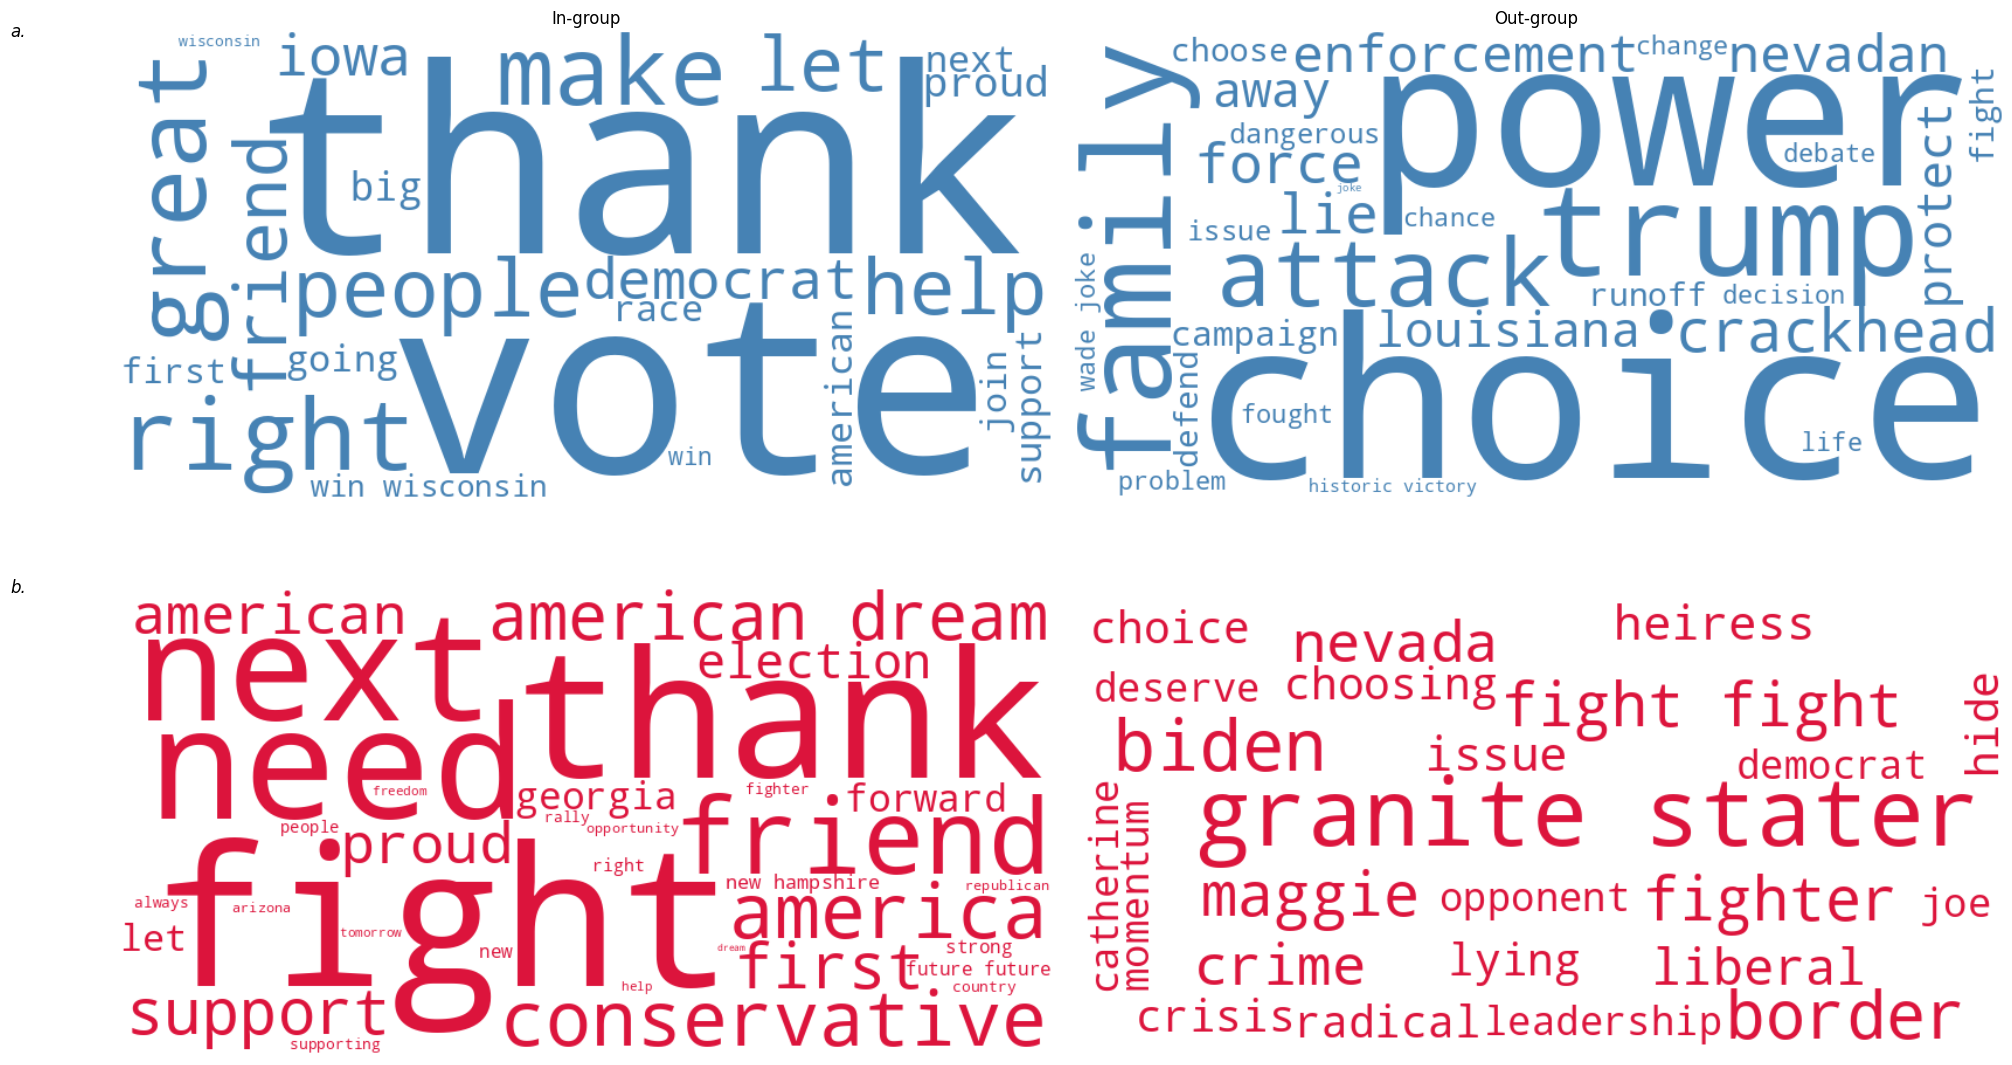

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
import colorsys

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define replacement and stopwords dictionaries
replace_dict = {
    # Example replacements
    'old_name1': 'new_name1',
    'old_name2': 'new_name2',
}

custom_stopwords = {
    'Ingroup_D': set(STOPWORDS),
    'Outgroup_D': set(STOPWORDS),
    'Ingroup_R': set(STOPWORDS),
    'Outgroup_R': set(STOPWORDS),
}

# Define frequency thresholds
frequency_thresholds = {
    'Ingroup_D': 10,   # Example threshold
    'Outgroup_D': 10,
    'Ingroup_R': 10,
    'Outgroup_R': 15
}

def preprocess_and_filter_text(texts, min_frequency):
    """
    Preprocesses and filters text data based on frequency thresholds.

    Parameters:
        texts (list): List of text strings to process.
        min_frequency (int): Minimum frequency threshold for words to be included.

    Returns:
        str: Processed and filtered text string.
    """
    if not texts:  # Check if the texts list is empty
        return ""  # Return an empty string if there are no texts to process

    # Tokenize and lowercase the text
    words = word_tokenize(" ".join(texts).lower())

    # Lemmatize and filter out non-alphabetic words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.isalpha()]

    # Count word frequencies
    word_counts = Counter(lemmatized_words)

    # Filter words based on the frequency threshold
    filtered_words = [
        word for word in lemmatized_words
        if word_counts[word] >= min_frequency
    ]

    return ' '.join(filtered_words) if filtered_words else ""

def calculate_word_sentiments(df):
    """
    Calculates average sentiment scores for each word in the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'clean_text_deep' and 'Sentiment' columns.

    Returns:
        dict: Dictionary mapping words to their average sentiment scores.
    """
    word_sentiment = {}

    for _, row in df.iterrows():
        words = word_tokenize(row['clean_text_deep'].lower())
        lemmatized = [lemmatizer.lemmatize(word) for word in words if word.isalpha()]
        for word in lemmatized:
            if word not in word_sentiment:
                word_sentiment[word] = []
            word_sentiment[word].append(row['Sentiment'])

    # Average the sentiment scores
    for word in word_sentiment:
        word_sentiment[word] = np.mean(word_sentiment[word])

    return word_sentiment

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    """
    Determines the color of words in the word cloud based on party affiliation.

    Parameters:
        word (str): The word to color.
        font_size (int): Size of the font.
        position (tuple): Position of the word.
        orientation (str): Orientation of the word.
        random_state (int, optional): Random state.
        **kwargs: Additional keyword arguments.

    Returns:
        str: Hex color code.
    """
    party = kwargs.get('party', 'D')
    return "steelblue" if party == 'D' else "#DC143C"  # Base colors for each party

def perform_wordcloud_generation(filtered_df, frequency_thresholds, word_sentiment):
    """
    Generates and displays word clouds for different group and party affiliations.

    Parameters:
        filtered_df (pd.DataFrame): Preprocessed DataFrame containing sentiment and text data.
        frequency_thresholds (dict): Dictionary mapping group_party to minimum frequency thresholds.
        word_sentiment (dict): Dictionary mapping words to their average sentiment scores.
    """
    # Define subsets for word clouds
    groups_parties = [('Ingroup', 'D'), ('Outgroup', 'D'), ('Ingroup', 'R'), ('Outgroup', 'R')]

    # Define titles for subplots
    titles = ['In-group Democrats', 'Out-group Democrats', 'In-group Republicans', 'Out-group Republicans']

    # Define figure and axes for the subplot
    fig, axs = plt.subplots(2, 2, figsize=(20, 12))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, (ax, (group, party)) in enumerate(zip(axs.flatten(), groups_parties)):
        subset = filtered_df[(filtered_df['Group'] == group) & (filtered_df['screen_name_party'] == party)]
        texts = subset['clean_text_deep'].dropna().tolist()
        key = f'{group}_{party}'
        min_freq = frequency_thresholds.get(key, 10)

        processed_text = preprocess_and_filter_text(texts, min_freq)

        wordcloud = WordCloud(
            background_color='white',
            stopwords=custom_stopwords.get(key, set()),
            width=800,
            height=400,
            color_func=lambda *args, **kwargs: color_func(*args, party=party, **kwargs)
        ).generate(processed_text)

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(titles[i], fontsize=12)

        # Add subplot annotations
        subplot_labels = ['a.', 'b.', 'c.', 'd.']
        ax.text(
            -0.1, 1.03, subplot_labels[i],
            transform=ax.transAxes, fontsize=12,
            fontstyle='italic', va='top', ha='right'
        )

    # Create a custom legend
    custom_legend = [
        Patch(facecolor='steelblue', label='Democrats'),
        Patch(facecolor='#DC143C', label='Republicans')
    ]
    fig.legend(
        handles=custom_legend,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=2,
        fontsize=12
    )

    # Add main title to the figure
    plt.suptitle('Word Clouds of Sentiment-Associated Words (2022)', fontsize=16, fontweight='bold', y=1.02)

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

def main():
    """
    Main function to execute data loading, preprocessing, sentiment calculation, and word cloud generation.
    """
    # Define file path
    file_path = '/path/to/PSVI_Raw_2022Midterm_SNA_SentiGPT_New.csv'

    # Load the dataset
    try:
        filtered_df = pd.read_csv(file_path, encoding='utf-8')
    except FileNotFoundError:
        print(f"File not found at the specified path: {file_path}")
        return
    except pd.errors.EmptyDataError:
        print("No data found in the CSV file.")
        return
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return

    # Replace values in 'screen_name' and 'connected_screen_name'
    filtered_df['screen_name'] = filtered_df['screen_name'].replace(replace_dict)
    filtered_df['connected_screen_name'] = filtered_df['connected_screen_name'].replace(replace_dict)

    # Clean and preprocess the data
    if 'Sentiment' in filtered_df.columns:
        filtered_df.drop(columns=['Sentiment'], inplace=True, errors='ignore')
    filtered_df.rename(columns={'StandardizedSentiment': 'Sentiment'}, inplace=True)

    # Map sentiment labels to numerical values
    sentiment_mapping = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
    if 'Sentiment' in filtered_df.columns:
        filtered_df['Sentiment'] = filtered_df['Sentiment'].map(sentiment_mapping)
        filtered_df = filtered_df[filtered_df['Sentiment'] != 0]
    else:
        print("Sentiment column not found after renaming.")
        return

    # Calculate average sentiment for each word
    word_sentiment = calculate_word_sentiments(filtered_df)

    # Perform word cloud generation
    perform_wordcloud_generation(filtered_df, frequency_thresholds, word_sentiment)

# Execute the main function
if __name__ == "__main__":
    main()